# 3.2) 비트코인 시세 예측하기

### 바로가기

- [<Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기](#<Step1.-탐색>-:-시간정보가-포함된-데이터-살펴보기)
    - [market price 데이터셋의 기본 정보]
    - [시계열 데이터 살펴보기]
- [<Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측](#<Step2.-예측>-:-파이썬-라이브러리를-활용한-시세-예측)
    - [ARIMA 모델 활용하기]
    - [Facebook Prophet 활용하기]
- [<Step3. 활용> : 더 나은 결과를 위한 방법들](#<Step3.-활용>-:-더-나은-결과를-위한-방법들)
    - [상한가 및 하한가 선정]
    - [이상치 제거하기]
    - [하이퍼 파라미터 선정하기]
- [재미로 알아보는 내일의 비트코인 시세](#재미로-알아보는-내일의-비트코인-시세)

-----

# <Step1. 탐색> : 시간정보가 포함된 데이터 살펴보기

## 시계열 데이터 
* 일정한 시간동안 수집 된 일련의 순차적으로 정해진 데이터 셋의 집합 
* 특징 시간에 관해 순서가 매겨져 있다는 점과, 연속한 관측치는 서로 상관관계를 갖고 있습니다.

 

+  즉, 시계열 데이터의 분석 목적은 시계열이 갖고 있는 법칙성을 발견해 이를 모형화하고, 또 추정된 모형을 통하여 미래의 값을 forecasting 하는 것

### [market price 데이터셋의 기본 정보]

In [152]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [153]:
# Data Source : https://www.blockchain.com/ko/charts/market-price?timespan=60days

file_path = '/Users/donggunhan/Downloads/2022_10_market-price.csv'
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])

In [154]:
# 기본 정보를 출력합니다.
print(bitcoin_df.shape)
print(bitcoin_df.info())

(366, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     366 non-null    object 
 1   price   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


In [155]:
bitcoin_df.head()

,day,price
0,2021-10-13 00:00:00,56242.94
1,2021-10-14 00:00:00,57406.69
2,2021-10-15 00:00:00,57397.74
3,2021-10-16 00:00:00,61641.17
4,2021-10-17 00:00:00,60948.78


-----

### [시계열 데이터 살펴보기]

In [156]:
bitcoin_df.head()

,day,price
0,2021-10-13 00:00:00,56242.94
1,2021-10-14 00:00:00,57406.69
2,2021-10-15 00:00:00,57397.74
3,2021-10-16 00:00:00,61641.17
4,2021-10-17 00:00:00,60948.78


In [157]:
bitcoin_df.tail()

,day,price
361,2022-10-09 00:00:00,19417.73
362,2022-10-10 00:00:00,19441.88
363,2022-10-11 00:00:00,19132.52
364,2022-10-12 00:00:00,19049.64
365,2022-10-13 00:00:00,19156.21


In [158]:
bitcoin_df.describe()

,price
count,366.000000
mean,36697.827705
std,13893.406518
min,18507.360000
25%,22480.795000
50%,38363.550000
75%,45853.575000
max,67562.170000


In [159]:
# to_datetime으로 day 피처를 시계열 피처로 변환합니다. 
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day']) 

In [160]:
# day 데이터프레임의 index로 설정합니다.
bitcoin_df.index = bitcoin_df['day']

bitcoin_df.set_index('day',inplace=True) #.set_index():기존에 있는 칼럼을 새로운 index로 지정
                                         #keys="index로 지정할 칼럼", drop="keys로 지정된 칼럼 삭제 여부"
bitcoin_df.head()

,price
day,
2021-10-13,56242.94
2021-10-14,57406.69
2021-10-15,57397.74
2021-10-16,61641.17
2021-10-17,60948.78


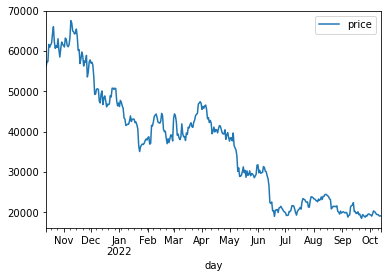

In [161]:
# 일자별 비트코인 시세를 시각화합니다.
bitcoin_df.plot()
plt.show()

-----

# <Step2. 예측> : 파이썬 라이브러리를 활용한 시세 예측

### ARIMA (Autoregressive Integrated Moving Average)
* 전통 적인 시계열 예측 방법으로 크게 두 가지 개념을 포함
* 첫 번째는 자기 자신의 과거를 정보로 사용하는 개념. 이는 ‘현재의 상태는 이전의 상태를 참고해서 계산된다’라는 아이디어를 전제
* 두 번째는 ‘이전 항에서의 오차를 이용하여 현재 항의 상태를 추론 하겠다’라는 방법. 그리고 이 둘을 합친 것을 ARMA 모델이라고 하며, 조금 더 나아간 ARIMA 모델은 ARMA 모델에 추세 변동의 경향성까지 반영한 방법

---


* AR: 자기회귀(Autoregression). 이전 관측값의 오차항이 이후 관측값에 영향을 주는 모형이다. 아래 식은 제일 기본적인 AR(1) 식으로, theta는 자기상관계수, epsilon은 white noise이다. Time lag은 1이 될수도 있고 그 이상이 될 수도 있음
* I: Intgrated. 누적을 의미하는 것으로, 차분을 이용하는 시계열모형들에 붙이는 표현이라고 생각하면 편함
* MA: 이동평균(Moving Average). 관측값이 이전의 연속적인 오차항의 영향을 받는다는 모형


### [ARIMA 모델 활용하기]

###### ARIMA 모델 학습

ARIMA 클래스의 order=(2,1,2) 라고 입력되어진 파라미터는 'AR이 몇 번째 과거까지를 바라보는 지에 대한 파라미터(2)','차분(Difference)에 대한 파라미터(1)', 'MA가 몇번째 과거까지를 바라보는 지에 대한 파라미터(2)'를 의미

* cf) 차분 : 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할, 앞서말한 ARIMA 모델의 결향성을 의미

In [162]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.arima_model as smt
import statsmodels.api as sm

https://splunktool.com/futurewarning-statsmodelstsaarimamodelarma-and-statsmodelstsaarimamodelarima-have-been-deprecated

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c', full_output=True, disp=True)
print(model_fit.summary())

In [163]:
# (AR=2, 차분=1, MA=2) 파라미터로 ARIMA 모델을 학습합니다.
model = sm.tsa.arima.ARIMA(bitcoin_df.price.values, order=(2,1,2))

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  366
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3134.274
Date:                Sat, 15 Oct 2022   AIC                           6278.548
Time:                        16:10:21   BIC                           6298.048
Sample:                             0   HQIC                          6286.297
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0150      0.370     -0.040      0.968      -0.740       0.710
ar.L2          0.7436      0.270      2.754      0.006       0.214       1.273
ma.L1          0.0686      0.380      0.181      0.8

-----

###### 모델의 성능 & 예측 결과 시각화
- 학습한 모델이 학습 데이터에 대해서 예측한 결과만을 시각화합니다.

In [149]:
from statsmodels.graphics.tsaplots import plot_predict

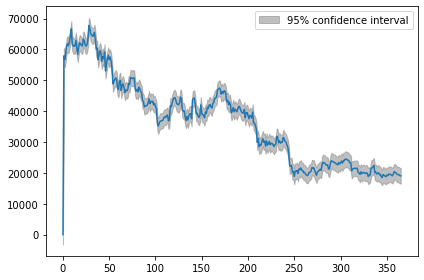

In [150]:
plot_predict(model_fit)
plt.tight_layout()

fig = model_fit.plot_predict() # 학습 데이터에 대한 예측 결과입니다. (첫번째 그래프)

<AxesSubplot:>

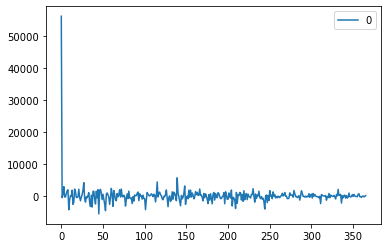

In [146]:

residuals = pd.DataFrame(model_fit.resid) # 잔차의 변동을 시각화합니다. (두번째 그래프)
residuals.plot()

ㄹㄹ###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [115]:
forecast_data = model_fit.forecast(steps=5) # 학습 데이터셋으로부터 5일 뒤를 예측합니다.

# 테스트 데이터셋을 불러옵니다.
test_file_path = '.
./data/market-price-test.csv'
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

SyntaxError: EOL while scanning string literal (1751260048.py, line 4)

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

-----

### [Facebook Prophet 활용하기]

- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - (env_name) `conda install -c conda-forge fbprophet`
- prophet의 input data columns는 'ds'와 'y'로 고정되어야 합니다.
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미합니다. 비트코인 데이터의 경우 대부분의 주기마다 트렌드성이 반영되는 것이 좋습니다.
- changepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측합니다. 수치가 높을수록 overfitting에 가까워집니다.

In [ ]:
! pip install prophet

###### Prophet 모델 학습

* 시계열 데이터의 트렌드성 (연간/월간/일간)을 예측하는 것에 초점
* 여러 시즌의 과거 데이터가 있는 시계열에서 가장 잘 작동

In [ ]:

from prophet import Prophet

In [ ]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative',  # 연간， 월간， 주간， 일간 등의 트렌드성을 반영하는 것을 의미하는 따라미터
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

-----

###### 모델로부터 예측할 기간을 정의하고, 결과를 도출.

In [ ]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d') #freq='d':날짜기준 
forecast_data = prophet.predict(future_data)

In [ ]:
forecast_data.tail()

In [ ]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

-----

###### 결과의 시각화

- 전체 데이터를 기반으로 학습한, 5일 단위의 예측 결과를 시각화합니다.

In [ ]:
fig1 = prophet.plot(forecast_data)

-----

- seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화합니다.

In [ ]:
fig2 = prophet.plot_components(forecast_data)

-----

###### 모델의 성능
- 실제 가격과 예측한 가격간의 차이 : 첫 5일과 마지막 5일은 제외하고 계산합니다.

In [ ]:
y = bitcoin_df.y.values[5:] # 첫 5일을 제외한 실제 가격 데이터입니다.
y_pred = forecast_data.yhat.values[5:-5] # 첫 5일, 마지막 5일을 제외한 예측 가격 데이터입니다.

In [ ]:
rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print(rmse)
print(r2)

-----

###### 실제 데이터와의 비교
- 예측 결과인 마지막 5일의 예측값을 실제 데이터와 비교해봅니다.
- 5일 후의 실제 데이터는 `'../data/market-price-test.csv'` 에서 불러올 수 있습니다. 데이터를 직접 다운로드(https://www.blockchain.com/ko/charts/market-price?timespan=60days) 하여 여러분이 직접 만든 모델을 마음대로의 기간으로 예측해 보세요.

In [116]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

pred_y = forecast_data.yhat.values[-5:] # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = bitcoin_test_df.y.values # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
pred_y_lower = forecast_data.yhat_lower.values[-5:] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = forecast_data.yhat_upper.values[-5:] # 마지막 5일의 예측 데이터의 최대값입니다.

FileNotFoundError: [Errno 2] No such file or directory: '../data/market-price-test.csv'

In [117]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

NameError: name 'pred_y' is not defined

In [118]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

NameError: name 'pred_y' is not defined

-----

In [119]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

NameError: name 'pred_y' is not defined

-----

# <Step3. 활용> : 더 나은 결과를 위한 방법들

### [상한가 및 하한가 선정]

- 주가데이터의 경우 의미가 없지만, 일반적인 시계열 데이터의 경우 상한값 혹은 하한값을 잘 설정해주는 것이 도움이 되기도 합니다.

In [120]:
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])

# 상한가를 설정합니다.
bitcoin_df['cap'] = 20000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정합니다.
prophet = Prophet(seasonality_mode='multiplicative', 
                  growth='logistic',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

16:05:54 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
# 5일을 내다보며 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')

# 상한가를 설정합니다.
future_data['cap'] = 20000
forecast_data = prophet.predict(future_data)

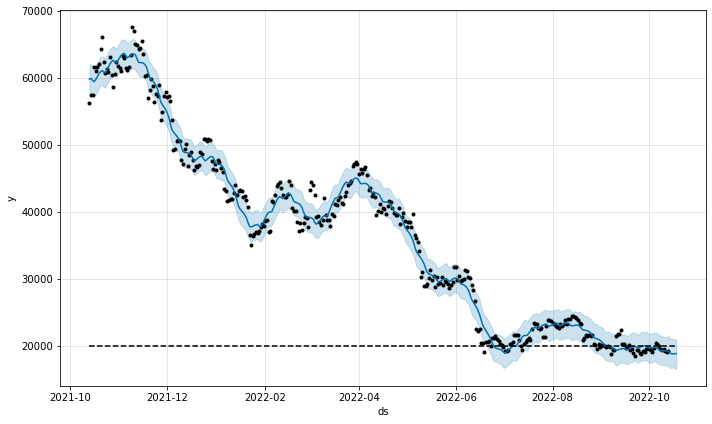

In [122]:
fig = prophet.plot(forecast_data)

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 상한선을 둠으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.

In [123]:
bitcoin_test_df = pd.read_csv(test_file_path, names=['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

FileNotFoundError: [Errno 2] No such file or directory: '../data/market-price-test.csv'

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

-----

In [ ]:
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

-----

### [이상치 제거하기]

- 가격이 18000을 넘어가는 값을 이상치로 판단하여 제거합니다.

In [124]:
# 18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names=['ds', 'y'])
bitcoin_df.loc[bitcoin_df['y'] > 18000, 'y'] = None

In [125]:
# prophet 모델을 학습합니다.
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

# 예측 결과를 그래프로 출력합니다.
fig = prophet.plot(forecast_data)

ValueError: Dataframe has less than 2 non-NaN rows.

-----

###### 실제 데이터와의 비교
- 비트코인 데이터의 경우, 이상치를 제거함으로써 오히려 예측력이 다소 떨어지는 결과를 보였습니다.
- 모델의 정확도 스코어 측면에서는 떨어졌지만, 트렌드 예측의 측면에서는 다소 나은 모습을 보여줄 수도 있습니다.

In [126]:
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 모델이 예상한 마지막 5일의 가격 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

FileNotFoundError: [Errno 2] No such file or directory: '../data/market-price-test.csv'

In [ ]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red") # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue") # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

In [127]:
plt.plot(pred_y, color="gold") # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="green") # 실제 가격 그래프입니다.

NameError: name 'pred_y' is not defined

-----

In [128]:
# 테스트 데이터의 RMSE를 출력합니다.
rmse = sqrt(mean_squared_error(pred_y, test_y))
print(rmse)

NameError: name 'pred_y' is not defined

-----

### `한걸음 더 나아가기`

### [ARIMA 모델의 하이퍼 파라미터 선정하기]

###### 적절한 파라미터 선정하기
- ARIMA 모델은 p,d,q 세 가지 파라미터를 적절하게 선정하는 것이 가장 중요합니다.
- ACF(Autocorrelation function), PACF(Partial autocorrelation function) 그래프를 통해 대략적인 파라미터를 선정합니다.

In [129]:
bitcoin_df = pd.read_csv(file_path, names = ['day', 'price'])
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace=True)

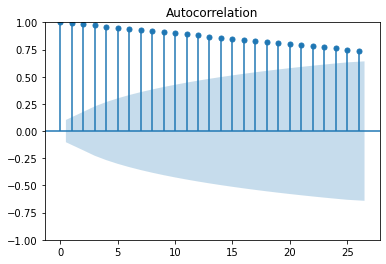

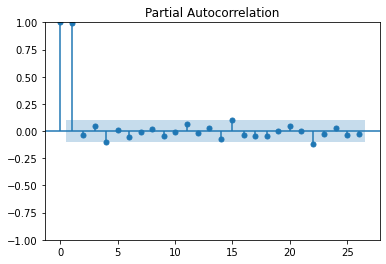

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin_df.price.values)
plot_pacf(bitcoin_df.price.values)
plt.show()

-----

###### ARIMA 모델 학습
- 그래프를 토대로 1차 학습

In [131]:
model = ARIMA(bitcoin_df.price.values, order=(15,2,0))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


-----

- 1차 결과를 토대로 2차 학습

In [132]:
model = ARIMA(bitcoin_df.price.values, order=(2,1,2))
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


-----

# 재미로 알아보는 내일의 비트코인 시세

###### 좋은 예측력을 보였던 Prophet 모델로 향후 5일간의 비트코인 시세를 예측해 봅시다.

In [133]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 합니다 : 'ds', 'y'
bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)

16:05:56 - cmdstanpy - INFO - Chain [1] start processing
16:05:56 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
# 5일단위의 미래를 예측합니다.
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

In [135]:
# 테스트 데이터를 불러옵니다.
bitcoin_test_df = pd.read_csv(test_file_path, names = ['ds', 'y'])

# 마지막 5일의 데이터를 가져옵니다.
pred_y = forecast_data.yhat.values[-5:]
test_y = bitcoin_test_df.y.values
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

FileNotFoundError: [Errno 2] No such file or directory: '../data/market-price-test.csv'

In [ ]:
plt.plot(pred_y, color="red", ls="--", marker="o", ms=5) # 모델이 예상한 가격 그래프입니다.
plt.plot(test_y, color="blue") # 실제 가격 그래프입니다.